In [1]:
import pandas as pd
import numpy as np
import glob
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import os
from keras import layers
tf.test.is_gpu_available()

Using TensorFlow backend.


True

In [2]:
df= pd.read_csv("../../scene-classification/train.csv")

df = df.replace(0,'buildings').replace(1,'forest').replace(2,'glacier').replace(3,'mountain').replace(4,'sea').replace(5,'street')

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import preprocessing

datagen = ImageDataGenerator(rescale=1./255,
                           shear_range = 0.2,
                           zoom_range = 0.2,
                           horizontal_flip=True,
                           preprocessing_function= preprocess_input,  
                           validation_split=0.25)
train_generator = datagen.flow_from_dataframe(dataframe=df,
                        directory="../../scene-classification/train",
                        x_col="image_name",
                        y_col="label",
                        subset="training",
                        batch_size=16,
                        class_mode="categorical",
                        target_size=(150,150))
valid_generator = datagen.flow_from_dataframe(dataframe=df,
                        directory="../../scene-classification/train",
                        x_col="image_name",
                        y_col="label",
                        subset="validation", 
                        batch_size=10,
                        class_mode="categorical",
                        target_size=(150,150))

Found 12776 validated image filenames belonging to 6 classes.
Found 4258 validated image filenames belonging to 6 classes.


In [10]:
from keras.applications.vgg16 import VGG16
vgg_conv = VGG16(weights = 'imagenet',include_top = False, input_shape = (150,150,3))

In [11]:
import tensorflow as tf
print(tf.__version__)

for layer in vgg_conv.layers[8:]:
    layer.trainable = True

for layer in vgg_conv.layers:
    print(layer,layer.trainable)
    

1.14.0
<keras.engine.input_layer.InputLayer object at 0x7fad10789080> False
<keras.layers.convolutional.Conv2D object at 0x7fad107890f0> True
<keras.layers.convolutional.Conv2D object at 0x7fad10789320> True
<keras.layers.pooling.MaxPooling2D object at 0x7fad10789dd8> True
<keras.layers.convolutional.Conv2D object at 0x7fad001b0080> True
<keras.layers.convolutional.Conv2D object at 0x7fad10410eb8> True
<keras.layers.pooling.MaxPooling2D object at 0x7fad10425978> True
<keras.layers.convolutional.Conv2D object at 0x7fad10425a90> True
<keras.layers.convolutional.Conv2D object at 0x7fad10398cc0> True
<keras.layers.convolutional.Conv2D object at 0x7fad103b0588> True
<keras.layers.pooling.MaxPooling2D object at 0x7fad1006dba8> True
<keras.layers.convolutional.Conv2D object at 0x7fad1008b1d0> True
<keras.layers.convolutional.Conv2D object at 0x7fad1003c128> True
<keras.layers.convolutional.Conv2D object at 0x7fad10055048> True
<keras.layers.pooling.MaxPooling2D object at 0x7fad001c4dd8> True


In [26]:
from keras import models,layers,optimizers
model_vgg = models.Sequential()
model_vgg.add(vgg_conv)
model_vgg.add(layers.Flatten())
model_vgg.add(layers.Dense(1024,  activation='relu'))
model_vgg.add(layers.Dropout(0.4))
model_vgg.add(layers.Dense(6,activation = 'softmax'))

model_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              8389632   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 6150      
Total params: 23,110,470
Trainable params: 23,110,470
Non-trainable params: 0
_________________________________________________________________


In [23]:
from keras import models,layers,optimizers
from keras.models import Model
x = vgg_conv.output
x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1024, activation="relu")(x)
predictions = layers.Dense(6, activation="softmax")(x)
model_vgg = Model(input = vgg_conv.input, output = predictions)
model_vgg.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [27]:
# model_vgg.compile(loss='categorical_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4),metrics=['acc'])
model_vgg.compile(optimizer=optimizers.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [28]:
history = model_vgg.fit_generator(train_generator, 
                                  steps_per_epoch = train_generator.samples/train_generator.batch_size,
                                  epochs = 10, validation_data=valid_generator, validation_steps = 80, use_multiprocessing = True)


Epoch 1/10
799/798 [==============================] - 217s 271ms/step - loss: 0.8688 - acc: 0.7386 - val_loss: 0.6244 - val_acc: 0.8387
Epoch 2/10
799/798 [==============================] - 217s 271ms/step - loss: 0.7038 - acc: 0.8005 - val_loss: 0.5191 - val_acc: 0.8275
Epoch 3/10
799/798 [==============================] - 216s 271ms/step - loss: 0.7395 - acc: 0.8017 - val_loss: 1.0520 - val_acc: 0.6600
Epoch 4/10
799/798 [==============================] - 216s 271ms/step - loss: 0.7521 - acc: 0.7920 - val_loss: 0.6247 - val_acc: 0.8037
Epoch 5/10
799/798 [==============================] - 216s 271ms/step - loss: 0.7131 - acc: 0.7880 - val_loss: 0.5115 - val_acc: 0.8484
Epoch 6/10
799/798 [==============================] - 216s 271ms/step - loss: 0.7760 - acc: 0.7937 - val_loss: 0.5218 - val_acc: 0.8587
Epoch 7/10
799/798 [==============================] - 216s 271ms/step - loss: 0.7892 - acc: 0.7830 - val_loss: 0.6502 - val_acc: 0.7662
Epoch 8/10
799/798 [============================

In [ ]:
from keras.callbacks import ModelCheckpoint
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

history =model_vgg.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator, callbacks=[checkpointer],
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20,verbose=1)

In [36]:
model_vgg.save("../../model_weights/VGG16Model.h5")

In [35]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model_vgg.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)

[0.9697843304407308, 0.7615348383952669]

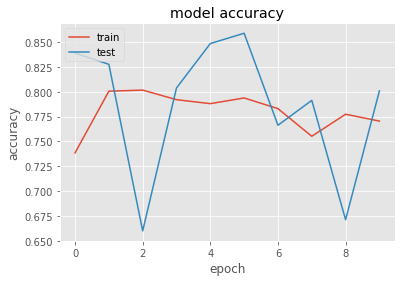

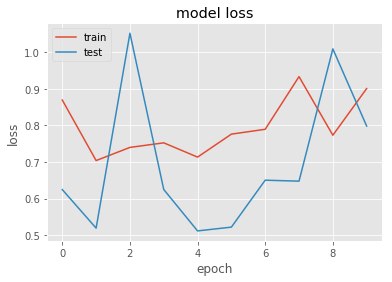

In [38]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()